C:\Users\basil\AppData\Local\Temp\ipykernel_17324\1030365691.py:312: RuntimeWarning: divide by zero encountered in log
  ll = np.log(tnormpdf(r, 0.5*(v), self.std_prior))


0.37526300222567954

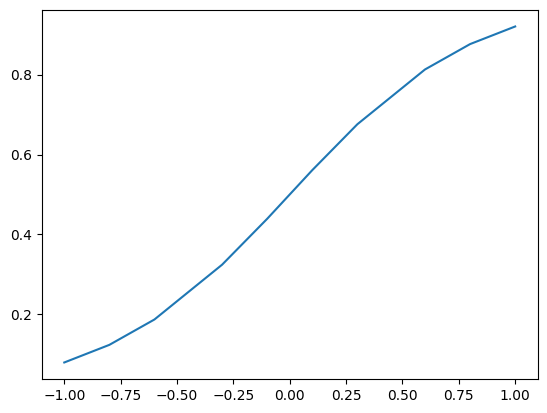

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels as sms
from firthlogist import FirthLogisticRegression

import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm, truncnorm
from scipy.stats import beta


def tnormpdf(x, loc, std, lb=0, ub=1):
    a, b = (lb-loc)/std, (ub-loc)/std
    return truncnorm.pdf(x, a, b)

def tnormrdn(loc, std, lb=0, ub=1, size=1):
    a, b = (lb-loc)/std, (ub-loc)/std
    return truncnorm(a, b, loc=loc, scale=std).rvs(size=size)


def logreg_regul(x, y, **kwargs):
    """
    Logistic regression with regularization
    adapted from Valentin Wyart's matlab code
    """

    ndat, nreg = x.shape

    # assert y.ndim == 2 and y.shape == (ndat, 1)

    fit_e = kwargs.get('fit_e', False)
    w_regul = kwargs.get('w_regul', False)
    nrun = kwargs.get('nrun', 10)
    b_sigma = kwargs.get('b_sigma', None)
    e_betab = kwargs.get('e_betab', None)
    flink = kwargs.get('flink', 'logit')

    if w_regul:
        w = np.mean(x != 0, axis=0)
    else:
        w = np.ones(nreg)

    b_min = -10 + np.zeros(nreg)
    b_max = +10 + np.zeros(nreg)
    e_min = 0
    e_max = 1

    if fit_e:
        p_min = np.concatenate((b_min, [e_min]))
        p_max = np.concatenate((b_max, [e_max]))
    else:
        p_min = b_min
        p_max = b_max

    def get_ll(p):
        b_tmp = p[:nreg]
        dv = x.dot(b_tmp)

        if flink == 'logit':
            pl = 1. / (1. + np.exp(-dv))
        elif flink == 'probit':
            pl = norm.cdf(dv)

        if fit_e:
            e_tmp = p[nreg]
            pl = e_tmp + (1 - e_tmp) * pl

        pl[y == 0] = 1 - pl[y == 0]
        ll = np.sum(np.log(np.maximum(pl, np.finfo(float).eps)))

        if b_sigma is not None:
            ll += np.sum(np.log(np.maximum(norm.pdf(b_tmp, 0,
                         b_sigma), np.finfo(float).eps)) * w)

        if fit_e and e_betab is not None:
            ll += np.log(np.maximum(beta.pdf(e_tmp, 1, e_betab),
                         np.finfo(float).eps))

        return -ll

    pval = np.empty((nrun, nreg + fit_e))
    fval = np.empty(nrun)

    for irun in range(nrun):
        if nrun == 1:
            b_ini = np.zeros(nreg)
        else:
            if b_sigma is not None:
                b_ini = np.random.normal(0, b_sigma, nreg)
            else:
                b_ini = np.random.uniform(-10, 10, nreg)

        if fit_e:
            if nrun == 1:
                e_ini = 0
            else:
                if e_betab is not None:
                    e_ini = np.random.beta(1, e_betab)
                else:
                    e_ini = np.random.uniform(0, 1)
            p_ini = np.concatenate((b_ini, [e_ini]))
        else:
            p_ini = b_ini

        result = minimize(get_ll, p_ini, bounds=list(
            zip(p_min, p_max)), options={'disp': True})
        pval[irun, :] = result.x
        fval[irun] = result.fun

    irun = np.argmin(fval)
    b = pval[irun, :nreg]
    e = pval[irun, nreg] if fit_e else 0

    return b, e


class QLearningModule:
    def __init__(self, lr, rl_temp, n_states, n_actions, q0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lr = lr
        self.rl_temp = rl_temp
        self.q = np.ones((n_states, n_actions)) * q0

    def value_update(self, s, a, r):
        self.q[s, a] += self.lr * (r - self.q[s, a])


class PerceptualModule:
    def __init__(self, perceptual_temp, perceptual_model, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.perceptual_temp = perceptual_temp
        self.perceptual_model = perceptual_model
        self.firth_fit = None
        self.logit_fit = None

    def get_p_destroy(self, hist_s, hist_r, model=None, sp1=None, sp2=None):
        if model is None:
            model = self.perceptual_model
        if sp1 is not None and sp2 is not None:
            to_select = np.array([sp1, sp2])
        else:
            to_select = np.arange(len(np.unique(hist_s)))

        if model == 'logit':
            self.logit_fit = sm.Logit(hist_r, sm.add_constant(hist_s))\
                .fit(disp=0)
            return self.logit_fit.predict(sm.add_constant(np.unique(hist_s)))[to_select]
        # elif model=='linear':
            # return sm.OLS(hist_r, sm.add_constant(hist_s))\
            # .fit().predict(sm.add_constant(np.unique(hist_s)))
        elif model == 'firth':
            self.firth_fit = FirthLogisticRegression(skip_ci=True, wald=False, fit_intercept=True)\
                .fit(sm.add_constant(hist_s), hist_r)
            return self.firth_fit.predict(sm.add_constant(np.unique(hist_s)))[to_select]
        elif model == 'val':
            vffd = [2, 2]
            # add constant to hist_s manually
            # create a new column of ones
            hist_s = np.column_stack((np.ones(len(hist_s)), hist_s))

            self.val_fit, _ = logreg_regul(
                hist_s, hist_r, b_sigma=vffd, nrun=1)
            # TODO: check if this is correct
            return 1/(1+np.exp(-self.val_fit[0]-self.val_fit[1]*np.unique(hist_s)))[to_select]
        else:
            raise ValueError(
                'model must be either logit, firth, or val. Model is {}'.format(model))

    def get_params(self, model=None):
        if model is None:
            model = self.perceptual_model
        if model == 'logit':
            return self.logit_fit.params
        # elif model=='linear':
            # return
        elif model == 'firth':
            return np.array(self.firth_fit.coef_)
        elif model == 'val':
            return self.val_fit
        else:
            raise ValueError('model must be either logit or linear')


class HybridModelMultiply(QLearningModule, PerceptualModule):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def make_choice(self, sr, hist_sp, hist_rp, sp1, sp2):
        def logsumexp(x):
            c = x.max()
            return c + np.log(np.sum(np.exp(x - c)))

        x = ((self.q[sr, :] * self.rl_temp)
             * (self.get_p_destroy(hist_sp, hist_rp, sp1=sp1, sp2=sp2)
             * self.perceptual_temp))

        p = np.exp(x - logsumexp(x))

        return np.random.choice(np.arange(2), p=p)


class HybridModelAdd(QLearningModule, PerceptualModule):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def make_choice(self, sr, hist_sp, hist_rp, sp1, sp2):
        def logsumexp(x):
            c = x.max()
            return c + np.log(np.sum(np.exp(x - c)))

        x1 = np.log(self.q[sr, :]) * self.rl_temp
        x2 = np.log(self.get_p_destroy(hist_sp, hist_rp,
                    sp1=sp1, sp2=sp2)) * self.perceptual_temp
        x = x1 + x2

        p = np.exp(x - logsumexp(x))

        try:
            return np.random.choice(np.arange(2), p=p)
        except ValueError as e:
            print(e)
            print(x1, x2, x)
            return np.random.choice(np.arange(2), p=[0.5, 0.5])


class KalmanFilter:
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)


class RandomModel:
    def __init__(self, *args, **kwargs):
        pass

    @staticmethod
    def make_choice(sr, hist_sp, hist_rp, sp1, sp2):
        return np.random.choice(np.arange(2))

    @staticmethod
    def rl_learn(s, a, r):
        pass


class NormativeModelPerceptual:
    def __init__(self, *args, **kwargs):
        # slope prior
        self.slope_prior = kwargs.get('slope', 2)
        # leak parameter
        self.leak = kwargs.get('leak', 0)
        # x values = forcefield values
        self.x = kwargs.get('x', np.arange(0, 10, 1))
        
        # possible values for the slope
        self.slope_range = kwargs.get(
        'slope_range', np.arange(-10, 10, 0.01))

        # initialize logposterior for the slope to prior
        self.lp_slope = np.log(norm.pdf(self.slope_range, 0, self.slope_prior))

        # define logit function
        self.logit = lambda x: 1 / (1+np.exp(x))
    

    def perceptual_update(self, destroyed, choice):
        v = -self.slope_range*choice if destroyed else self.slope_range*choice
        # compute log likelihood
        ll = np.log(self.logit(v))
        # update log posterior
        self.lp_slope += ll
        self._apply_leak()
    
    def predict(self, ff1=None, ff2=None):
        if ff1 is None and ff2 is None:
            # predict p(destroy) for all forcefields
            to_select = np.arange(len(self.x))
        else:
            # predict p(destroy) for 2 (displayed) forcefields
            to_select = np.array([ff1, ff2])
        return self.logit(-self.get_slope()*self.x[to_select])

    def get_slope(self):
        w = np.exp(self.lp_slope-np.max(self.lp_slope))
        slope = np.sum(w*self.slope_range)/np.sum(w)
        return slope
    #
    def _apply_leak(self):
        self.lp_slope *= 1-self.leak


class NormativeModelValue:
    def __init__(self, *args, **kwargs):
        self.sigma_prior = kwargs.get('sigma_prior', .2)
        self.std_prior = kwargs.get('std_prior', .2)
        self.leak = kwargs.get('leak', 0)
        self.nstate = kwargs.get('nstate', 2)

        # possible values for the difference between two options
        self.sigma_range = kwargs.get('sigma_range', np.arange(-1, 1, 0.002))

        # initialize logposterior for the slope to prior
        self.lp_sigma = [
            np.log(tnormpdf(0.5*(1+self.sigma_range), 0.5, self.sigma_prior))
            for _ in range(self.nstate)
        ]
    
    def value_update(self, s, r, a):
        v = 1-self.sigma_range if a else 1+self.sigma_range
        # compute log likelihood
        ll = np.log(tnormpdf(r, 0.5*(v), self.std_prior))
        # update log posterior
        self.lp_sigma[s] += ll
        self._apply_leak()

    def get_sigma(self, s):
        w = np.exp(self.lp_sigma[s]-np.max(self.lp_sigma[s]))
        sigma = np.sum(w*self.sigma_range)/np.sum(w)
        return sigma 

    def _apply_leak(self):
        self.lp_sigma *= 1-self.leak 


class NormativeModel(NormativeModelPerceptual, NormativeModelValue):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def make_choice(self, s, a, r):
        pass

    

h1 = HybridModelMultiply(lr=1, rl_temp=5, perceptual_temp=5,
                         n_states=2, n_actions=2, q0=50, perceptual_model='val')
h1.make_choice(0, np.array([0, 0, 1, 1]), np.array([0, 1, 0, 1]), 0, 1)
h2 = RandomModel(lr=1, rl_temp=5, perceptual_temp=5, n_states=2,
                 n_actions=2, q0=50, perceptual_model='val')
h2.make_choice(0, np.array([0, 0, 1, 1]), np.array([0, 1, 0, 1]), 0, 1)

# simulation perceptual training
# -----------------------------------------------------------------
n_perceptual_trials_per_color = 10
# states (colors coded by real probability of destroying the target)
sp = np.repeat(np.linspace(0, 1, 10).round(1), n_perceptual_trials_per_color).flatten()
# rewards (1 if target destroyed, 0 otherwise), using the real probabilities in s
rp = np.random.binomial(1, sp, size=len(sp))

sp = np.repeat(np.linspace(-1, 1, 10).round(1), n_perceptual_trials_per_color).flatten()

h3 = NormativeModelPerceptual(slope=2, leak=0, x=np.unique(sp))
for i in range(len(sp)):
    h3.perceptual_update(rp[i], sp[i])

plt.plot(h3.x, h3.predict())

s = np.repeat(np.arange(2), 100)
r = [[.6, .4], [.7, .3]]
a = [[0, 1], [0, 1]]
a = np.repeat(a, len(s)/4)
std = .2

h4 = NormativeModelValue(sigma_prior=.2, leak=0, nstate=1, std_prior=std)

# print(h4.lp_sigma)
for i in range(int(len(s)/2)):
    
    a_ = a[i]
    r_ = r[s[i]][a_]
    # print(s[i], r_, a_)
    h4.value_update(s[i], r_, a_)
 
np.mean(tnormpdf(.5, 0.5*(1+h4.sigma_range), .2))

In [3]:
import numpy as np
from scipy.stats import norm

def truncated_normal_pdf(x, m, s):
    x = x + np.zeros_like(m)
    p = norm.pdf(x, m, s)
    cdf_range = norm.cdf(1, m, s) - norm.cdf(0, m, s)
    p = p / (s * cdf_range)
    return p

# Example usage
x = np.array([0.5, 0.4, 0.6, 0.8])
m = 0.5
s = 0.2
pdf_values = truncated_normal_pdf(x, m, s)
print(pdf_values)

# Example usage
x = np.array([0.5, 0.4, 0.6, 0.8])
loc = 0.5
std = 0.1
pdf_values = tnormpdf(x, loc, std)
print(pdf_values)

[10.09897958  8.9123182   8.9123182   3.27865864]
[0.35206553 0.36827035 0.33322479 0.28969172]


c:\Users\basil\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\basil\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
c:\Users\basil\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\basil\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\basil\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmo

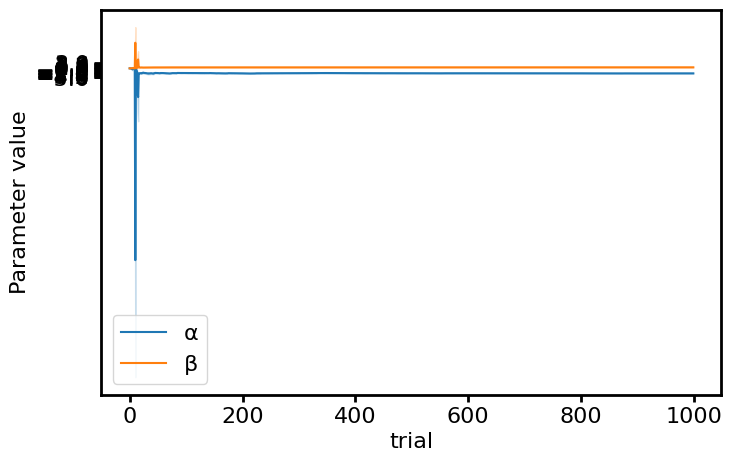

(0.0, 1.0)

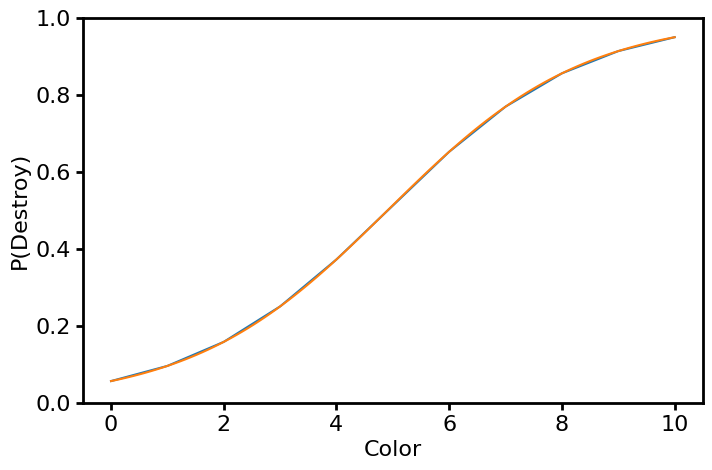

In [7]:
from matplotlib.animation import FuncAnimation
# import HTML
from IPython.display import HTML

# simulation perceptual training
# -----------------------------------------------------------------
n_perceptual_trials_per_color = 100
# states (colors coded by real probability of destroying the target)
sp = np.repeat(np.linspace(0, 1, 10).round(1), n_perceptual_trials_per_color).flatten()
# rewards (1 if target destroyed, 0 otherwise), using the real probabilities in s
rp = np.random.binomial(1, sp, size=len(sp))

sp = np.repeat(np.linspace(-1, 1, 10).round(1), n_perceptual_trials_per_color).flatten()


def create_frame(step, x1, y1, param, errcount, ax):
    ax.cla()
    sns.lineplot(x=x1[step], y=y1[step], ax=ax)
    plt.ylabel('P(Destroy)')
    # identity line
    plt.plot([0, 10], [0, 1], color='k', linestyle='--')
    plt.xlabel('Color')
    plt.ylim(0, 1)
    yticks = np.arange(0, 1.1, 0.1)
    xticks = np.arange(0, 11, 1)
    plt.yticks(yticks, [f'{y:.1f}' for y in yticks])
    plt.xticks(xticks, [f'{x:.0f}' for x in xticks])
    #also plot the parameters of logit model
    plt.annotate(f'α = {param[step][0]:.2f}\nβ = {param[step][1]:.2f}',
        xy=(0.05, 0.95), xycoords='axes fraction', fontsize=20, ha='left', va='top')
    # add ntrial to the top right corner
    plt.annotate(f'ntrial = {step+errcount}',
    xy=(0.95, 0.95), xycoords='axes fraction', fontsize=20, ha='right', va='top')


xx = []
yy = []
param = []
errcount = 0
a_param = []
for a in range(5):
    # states (colors coded by real probability of destroying the target)
    sp = np.array(
        [np.linspace(0, 1, 10).round(1) for _ in range(n_perceptual_trials_per_color)]
    ).flatten()
    # rewards (1 if target destroyed, 0 otherwise), using the real probabilities in s
    rp = np.array(
        [np.random.binomial(1, sp[i]) for i in range(len(sp))]
    ).flatten()
    
    m = HybridModelMultiply(lr=1, rl_temp=5, perceptual_temp=5, n_states=2, n_actions=2, q0=50, perceptual_model='logit')

    for i in range(len(sp)):
        try:
            x = np.unique(sp[:i]*10)
            y = m.get_p_destroy(sp[:i]*10, rp[:i])
            params = m.get_params()
            xx.append(x)
            yy.append(y)
            a_param.append({
                'α': params[0],
                'β': params[1],
                'trial': i,
                'agent': a,
            })
            param.append(params)
            
        except (sms.tools.sm_exceptions.PerfectSeparationError, ValueError, np.linalg.LinAlgError) as e:
        #     print(e)
            a_param.append({
                'α': 0,
                'β': 0,
                'trial': i,
                'agent': a,
            })

            errcount += 1
        #     pass


# fig, ax = plt.subplots(figsize=(6, 4))
# animation = FuncAnimation(fig, create_frame, frames=range(1, len(xx)), fargs=(xx, yy, param, errcount, ax))

# animation.save('animation.gif',  fps=3);
# HTML(animation.to_jshtml())


# plot the 2 parameters as two curves with different colors and standard mean error
# using seaborn
sns.lineplot(x='trial', y='α', data=pd.DataFrame(a_param), errorbar='se', label='α')
sns.lineplot(x='trial', y='β', data=pd.DataFrame(a_param), errorbar='se', label='β')
plt.yticks(np.arange(-5, 3.1, 0.4))
plt.legend()
plt.ylabel('Parameter value')
plt.show()

# plot last xx and yy
plt.figure()
plt.plot(xx[-1], yy[-1])
# plot logit model using parameters fitted
plt.plot(np.linspace(0, 10, 100), 1/(1+np.exp(-param[-1][0]-param[-1][1]*np.linspace(0, 10, 100))))
plt.ylabel('P(Destroy)')
plt.xlabel('Color')
plt.ylim(0, 1)


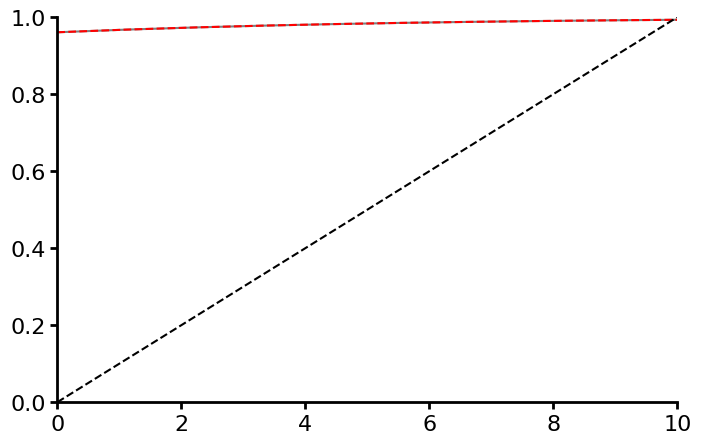

In [5]:
a = 3.2
b = .18

# logistic function
f = lambda x, a, b:  1 / (1 + np.exp(-(a+b*x)))
f2 = lambda x, a, b:  1 / (1 + np.exp(-a-b*x))
    

# nice plot size and fontsize
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['font.size'] = 16
# adapt the axes size and ticks
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['axes.linewidth'] = 2

# plot the function
x = np.linspace(0, 10, 10)
sns.lineplot(x=x, y=f2(x, a, b), color='k', alpha=.5)
sns.lineplot(x=x, y=f(x, a, b), color='r', linestyle='--')

assert np.allclose(f(x, a, b), f2(x, a, b))
# smart bounds on the y axis and x axis
plt.ylim(0, 1)
plt.xlim(0, 10)
sns.despine()

plt.plot([0, 10], [0, 1], color='k', linestyle='--')


In [6]:
# -----------------------------------------------------------------
# Full
# -----------------------------------------------------------------
# np.random.seed(0)

# parameters to tune
nagents = 1000
models = (RandomModel, HybridModelMultiply, HybridModelAdd)
conditions = [
    [60, 40],
    [80, 20]
]
std = 20

n_trials_per_condition = 50
conditions_idx = np.repeat(np.arange(len(conditions)), n_trials_per_condition)
ff1 = np.random.randint(0, 10, n_trials_per_condition*2)
ff2 = np.random.randint(0, 10, n_trials_per_condition*2)
p_ff = np.linspace(0, 1, 10)
ntrials = len(conditions_idx)

# generate random parameters
lr = np.random.uniform(0, 1, nagents)
rl_temp = np.random.normal(2, .8, nagents)
perceptual_temp = np.random.normal(2, .8, nagents)

# removes negative values and values > 1
lr[lr < 0] = 0
lr[lr > 1] = 1

rl_temp[rl_temp < 0] = 0
perceptual_temp[perceptual_temp < 0] = 0

#to fill
agents = []
df_list = []

from tqdm.notebook import tqdm
# if pbar exists
try:
    pbar.refresh()
except NameError:
    pass
pbar = tqdm(total=ntrials*nagents*len(models))

for model in models:
    for agent in range(nagents):

        m = model(
                lr=.5,#lr[agent]
                rl_temp=1,#rl_temp[agent]
                perceptual_temp=1,#perceptual_temp[agent],
                n_states=2,
                n_actions=2,
                q0=np.mean(conditions),
                perceptual_model='logit'
        )

        agents.append(m)
        model_name = model.__name__
        
        np.random.shuffle(ff1)
        np.random.shuffle(ff2)

        hist_sp = list(sp*10)
        hist_rp = list(rp)
        
        cumulative_reward = 0

        for t in range(ntrials):

            s_rl = conditions_idx[t]

            sp1 = ff1[t]
            sp2 = ff2[t]
            
            a = m.make_choice(s_rl, hist_sp, hist_rp, sp1, sp2)

            r = np.random.normal(conditions[s_rl][a], std) 
            
            cumulative_reward += r

            chosen_ff = sp1 if a == 0 else sp2
            unchosen_ff = sp2 if a == 0 else sp1

            destroyed = np.random.random() < p_ff[chosen_ff]
            
            if destroyed:
                m.rl_learn(s_rl, a, r)

            # add chosen ff to history
            hist_sp.append(chosen_ff)
            hist_rp.append(destroyed)
            
            #check that the model chose the best ff
            corr_ff = p_ff[chosen_ff] > p_ff[unchosen_ff]
            corr_rl = a == 0 

            unchosen = 1 if a == 0 else 0

            corr_full = corr_ff and corr_rl
            
            corr_ev = (conditions[s_rl][a] * p_ff[chosen_ff]) > (conditions[s_rl][unchosen] * p_ff[unchosen_ff])
            
            df_list.append({
                'trial': t,
                'chosen_ff': chosen_ff,
                'unchosen_ff': unchosen_ff,
                'choice': a,
                'unchosen': unchosen,
                'correct_ff': corr_ff,
                'correct_rl': corr_rl,
                'correct_full': corr_full,
                'correct_ev': corr_ev,
                'agent': agent,
                'rl_temp': rl_temp[agent],
                'perceptual_temp': perceptual_temp[agent],
                'learning_rate': lr[agent],
                'model': model_name,
                'cumulative_reward': cumulative_reward
            })
            pbar.update()
pbar.refresh()

df = pd.DataFrame(df_list)



  0%|          | 0/300000 [00:00<?, ?it/s]

AttributeError: 'HybridModelMultiply' object has no attribute 'rl_learn'

<AxesSubplot: xlabel='trial', ylabel='cumulative_reward'>

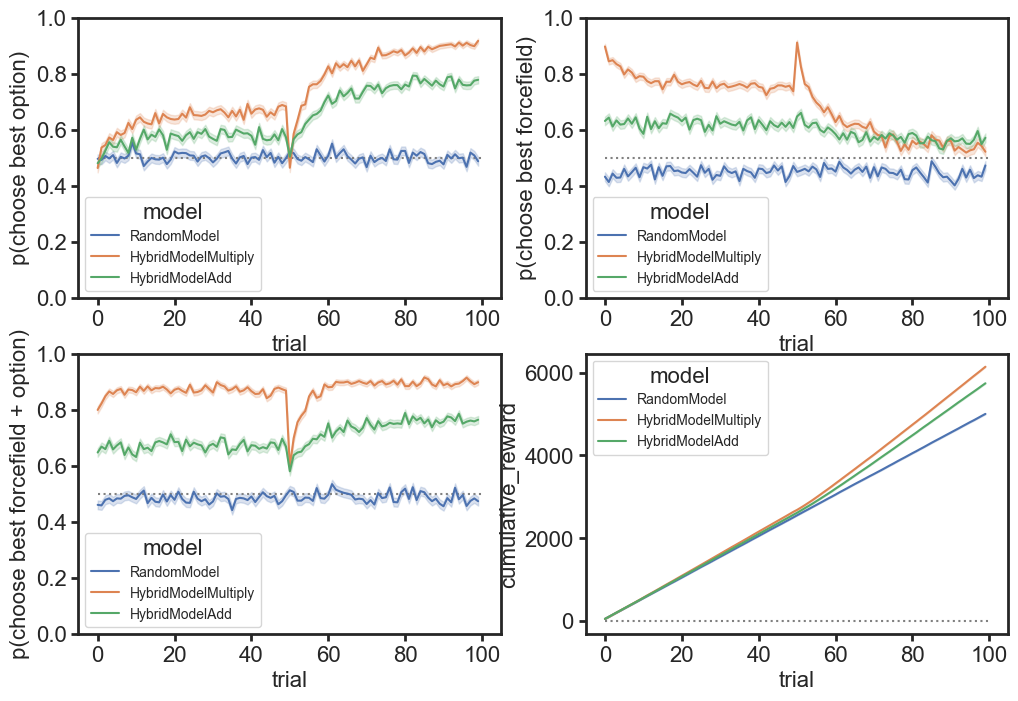

In [ ]:
sns.set({'figure.figsize': (12, 8)})
sns.set_style('ticks')
# set legend fontsize
plt.rcParams['legend.fontsize'] = 10

plt.subplot(2, 2, 1)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_rl', data=df, hue='model', n_boot=0, errorbar='se')
plt.ylabel('p(choose best option)')
plt.ylim(0, 1 )

plt.subplot(2, 2, 2)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_ff', data=df, hue='model', n_boot=0, errorbar='se')
plt.ylabel('p(choose best forcefield)')
plt.ylim(0, 1 )

plt.subplot(2, 2, 3)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_ev', data=df, hue='model', n_boot=0, errorbar='se')
plt.ylabel('p(choose best forcefield + option)')
plt.ylim(0, 1 )

plt.subplot(2, 2, 4)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='cumulative_reward', data=df, hue='model', n_boot=0, errorbar='se')
# plt.ylabel('choice (option A = 0 ; option B = 1)')
# plt.ylim(0, 1 )



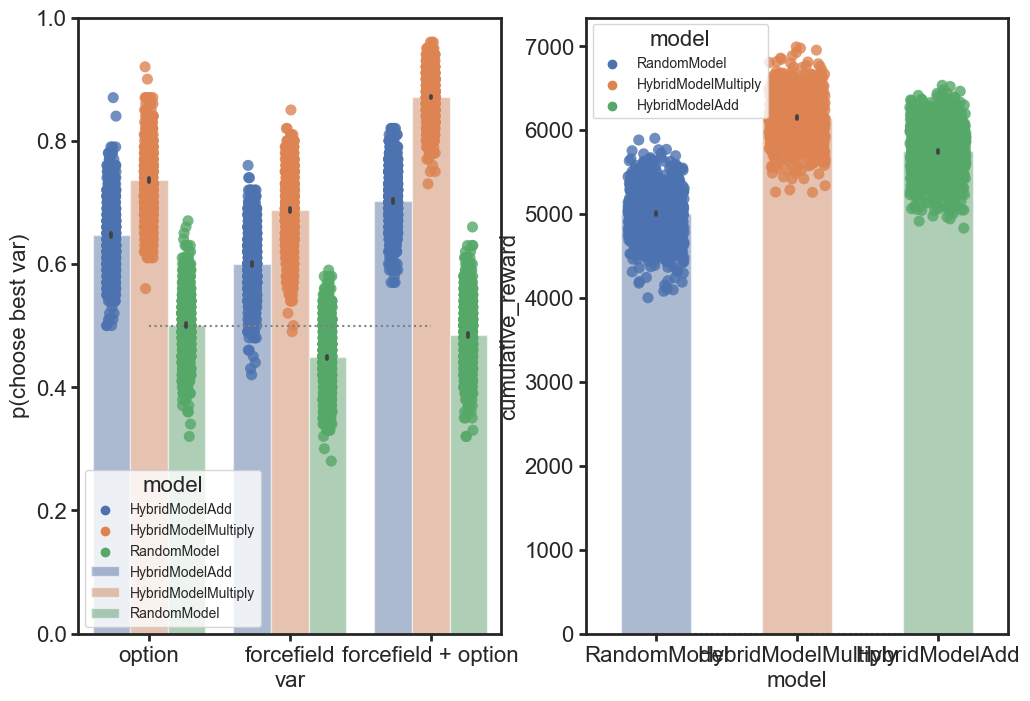

c:\Users\basil\AppData\Local\Programs\Python\Python310\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
c:\Users\basil\AppData\Local\Programs\Python\Python310\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-16.455068,199998,two-sided,8.458813e-61,"[-141.55, -111.42]",0.073589,2.855e+56,1.0


In [ ]:
sns.set({'figure.figsize': (12, 8)})
sns.set_style('ticks')

plt.subplot(1, 2, 1)
# plot dotted line at .5
plt.plot([0, 2], [.5, .5], color='grey', linestyle=':')
avg = df.groupby(['agent', 'model'], as_index=False).mean()
new_df = pd.DataFrame({'score': np.array([avg['correct_rl'], avg['correct_ff'], avg['correct_ev']]).flatten(), 'type': np.array(
    ['option',] * len(avg['correct_rl'])
    + ['forcefield',] * len(avg['correct_ff'])
    + ['forcefield + option',] * len(avg['correct_ev'])).flatten(),
    'model':np.array([avg['model'], avg['model'], avg['model']]).flatten()})

ax = sns.barplot(x='type', y='score', data=new_df,alpha=.5, zorder=0, hue='model', dodge=True)
plt.legend([],[], frameon=False)
sns.stripplot(x='type', y='score', data=new_df, hue='model', jitter=True, alpha=.8, size=8, zorder=1, dodge=True)
plt.ylabel('p(choose best var)')
plt.xlabel('var')
plt.xticks([0, 1, 2], ['option', 'forcefield', 'forcefield + option'])
plt.ylim(0, 1)


plt.subplot(1,2, 2)
# plot dotted line at .5
plt.plot([0, 2], [.5, .5], color='grey', linestyle=':')
last_trial = df[df['trial'] == 99]

ax = sns.barplot(x='model', y='cumulative_reward', data=last_trial, alpha=.5, zorder=0, width=.5)
sns.stripplot(x='model', y='cumulative_reward', data=last_trial, hue='model', jitter=.2, alpha=.8, size=8, zorder=1)
plt.show()

import pingouin as pg
pg.ttest(df[df['model'] == 'HybridModelAdd']['cumulative_reward'], df[df['model'] == 'HybridModelMultiply']['cumulative_reward'])



C:\Users\basil\AppData\Local\Temp\ipykernel_14016\144853987.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg = df.groupby('agent').mean()


(0.0, 1.0)

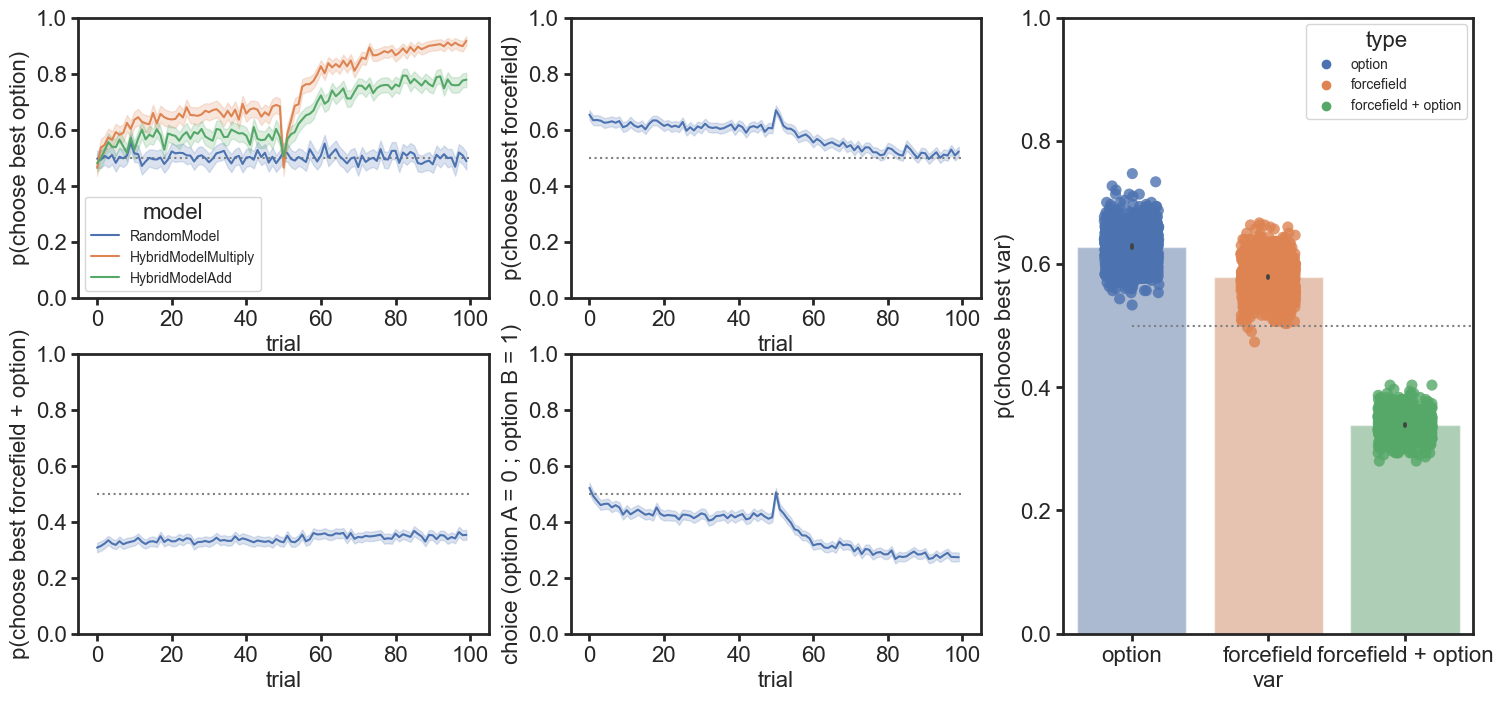

In [ ]:
sns.set({'figure.figsize': (18, 8)})
sns.set_style('ticks')

plt.subplot(2, 3, 1)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_rl', hue='model', data=df)
plt.ylabel('p(choose best option)')
plt.ylim(0, 1 )

plt.subplot(2, 3, 2)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_ff', data=df)
plt.ylabel('p(choose best forcefield)')
plt.ylim(0, 1 )

plt.subplot(2, 3, 4)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_full', data=df)
plt.ylabel('p(choose best forcefield + option)')
plt.ylim(0, 1 )

plt.subplot(2, 3, 5)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='choice', data=df)
plt.ylabel('choice (option A = 0 ; option B = 1)')
plt.ylim(0, 1 )

plt.subplot(1, 3, 3)
# plot dotted line at .5
plt.plot([0, 3], [.5, .5], color='grey', linestyle=':')
avg = df.groupby('agent').mean()
# 1s column = score, 2nd colum type ('rl', 'ff', 'full')
new_df = pd.DataFrame({'score': np.array([avg['correct_rl'], avg['correct_ff'], avg['correct_full']]).flatten(), 'type': np.array(
    ['option',] * len(avg['correct_rl'])
    + ['forcefield',] * len(avg['correct_ff'])
    + ['forcefield + option',] * len(avg['correct_full'])).flatten()})

sns.barplot(x='type', y='score', data=new_df,alpha=.5, zorder=0)
sns.stripplot(x='type', y='score', data=new_df, hue='type', jitter=.2, alpha=.8, size=8, zorder=1)
plt.ylabel('p(choose best var)')
plt.xlabel('var')
plt.xticks([0,1,2], ['option', 'forcefield', 'forcefield + option'])
plt.ylim(0,1)



In [ ]:
#plot the distribution of model parameters
sns.set({'figure.figsize':(11,8)})
sns.set_style('ticks')

params = pd.DataFrame(
    {
        'param': np.array(
            ['lr', ] * nagents
          + ['rl_temp', ] * nagents
          + ['perceptual_temp', ] * nagents
        ).flatten(),
        'value': np.array(
            [agent.lr for agent in agents]
          + [agent.rl_temp for agent in agents]
          + [agent.perceptual_temp for agent in agents]
        ).flatten(),
    }
)

fig, ax = plt.subplots(ncols=2, nrows=1)
print(ax)

sns.displot(
    data=params,
    x='value',
    hue='param',
    kind='kde',
    fill=True,
    palette='colorblind',
    # split distributions  into 3 layers
    # (one for each parameter)
    # to make the plot more readable
    ax=ax[0]
    
)

d = df.groupby(['agent'], as_index=False).mean()
d.drop(['trial', 'choice', 'chosen_ff', 'unchosen', 'unchosen_ff', 'agent'], axis=1, inplace=True)
# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax[1])


AttributeError: 'RandomModel' object has no attribute 'lr'